In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

In [2]:
# Problem generator

def create_problem(size, density=1.0, negative_values=False, noise_level=0.0, seed=42):
    """Generate a random weighted directed graph as adjacency matrix."""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        if rng.random() < density:
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round()

In [3]:
# Build graph from adjacency matrix

def build_graph(problem):
    masked = np.ma.masked_array(problem, mask=np.isinf(problem))
    G = nx.from_numpy_array(masked, create_using=nx.DiGraph)
    return G

In [ ]:
# NetworkX shortest path wrapper
# Updated after peer review suggestions
def nx_shortest_path(G, source, negative_values):
    """
    Compute shortest path distances from source to all nodes using NetworkX.
    Returns:
        distances: dict mapping node -> shortest distance from source
    """
    try:
        if negative_values:
            distances = nx.single_source_bellman_ford_path_length(G, source, weight='weight')
        else:
            distances = nx.single_source_dijkstra_path_length(G, source, weight='weight')
        return distances
    except (nx.NetworkXNoPath, nx.NetworkXUnbounded):
        return None

In [5]:
'''
from matplotlib import pyplot as plt

def draw_graph(G):
    # Plot the graph with edge weights
    if G.number_of_nodes() == 0:
        print("Graph is empty, nothing to plot.")
    else:
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(8,6))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        def _fmt_weight(w):
            try: return f'{float(w):.1f}'
            except Exception: return str(w)
        edge_labels = {(u, v): _fmt_weight(G[u][v].get('weight', '')) for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        plt.title('Visualization of the graph with edge weights')
        plt.show()
'''

'\nfrom matplotlib import pyplot as plt\n\ndef draw_graph(G):\n    # Plot the graph with edge weights\n    if G.number_of_nodes() == 0:\n        print("Graph is empty, nothing to plot.")\n    else:\n        pos = nx.spring_layout(G, seed=42)\n        plt.figure(figsize=(8,6))\n        nx.draw(G, pos, with_labels=True, node_color=\'lightblue\', edge_color=\'gray\')\n        def _fmt_weight(w):\n            try: return f\'{float(w):.1f}\'\n            except Exception: return str(w)\n        edge_labels = {(u, v): _fmt_weight(G[u][v].get(\'weight\', \'\')) for u, v in G.edges()}\n        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)\n        plt.title(\'Visualization of the graph with edge weights\')\n        plt.show()\n'

In [ ]:
# OPTIMIZED Bellman-Ford - runs once per source, computes all destinations
# Updated after peer review suggestions
def bellman_ford_custom(G, source):
    """
    Optimized Bellman-Ford implementation that computes shortest paths 
    from source to ALL other nodes in a single pass.
    
    Returns:
        distances: dict mapping node -> shortest distance from source
        predecessors: dict mapping node -> predecessor on shortest path
        
    Returns None, None if negative cycle is detected.
    """
    # Initialize distances (default to infinity) 
    # and predecessors to store the path history (default to None)
    distances = {node: float('inf') for node in G.nodes()}
    predecessors = {node: None for node in G.nodes()}
    distances[source] = 0 # Distance to source is 0
    
    n_nodes = G.number_of_nodes() # Cache the total number of nodes (|V|) to determine iteration limits
    
    # Worst-case requires |V| - 1 iterations
    for _ in range(n_nodes - 1):
        updated = False
        # Iterate over all edges (u, v) in the graph
        for u, v, data in G.edges(data=True): 
            # Extract edge weight, defaulting to infinity if missing for safety
            weight = data.get('weight', np.inf) 
            # If path through u is shorter than current path to v
            # Also ensures we don't add to infinity (reachability check)
            if distances[u] != float('inf') and distances[u] + weight < distances[v]: 
                # Update distance to v with the new minimal value
                distances[v] = distances[u] + weight
                predecessors[v] = u
                updated = True
        
        # Early termination if no updates: the algorithm has converged before the (V-1)th limit
        if not updated:
            break
    
    # Final scan to detect negative weight cycles
    # Negative cycle detection (Vth iteration)
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', np.inf)
        if distances[u] != float('inf') and distances[u] + weight < distances[v]:
            # Negative cycle detected
            return None, None
        
    # Return the computed shortest distances and the predecessor tree
    return distances, predecessors

In [8]:
# Benchmarking parameters
sizes = [10, 20, 50, 100, 200]#, 500, 1000]
densities = [0.2, 0.5, 0.8, 1.0]
noise_levels = [0.0, 0.1, 0.5, 0.8]
negative_values_opts = [False, True]

# Incremental sampling for large sizes
size_sampling = {50: 30, 100: 40, 200: 50, 500: 60, 1000: 70}

aggregate_results = []
total_combinations = len(sizes) * len(densities) * len(noise_levels) * len(negative_values_opts)
start_time = time.time()
progress = 0

print("Starting benchmark...")

for idx, (size, density, noise_level, negative_values) in enumerate(
    product(sizes, densities, noise_levels, negative_values_opts)
):
    # Determine sample sources
    if size in size_sampling:
        sample_n = size_sampling[size]
        sources = np.random.choice(size, sample_n, replace=False)
    else:
        sources = range(size)
    
    # Create problem
    problem = create_problem(size, density=density, noise_level=noise_level, 
                            negative_values=negative_values)
    G = build_graph(problem)
    
    # Collect costs and times
    nx_costs = []
    bf_costs = []
    nx_times = []
    bf_times = []
    
    # Process each source node
    for s in sources:
        # NetworkX timing
        nx_start = time.perf_counter()
        nx_distances = nx_shortest_path(G, s, negative_values)
        nx_end = time.perf_counter()
        nx_times.append(nx_end - nx_start)
        
        # Bellman-Ford custom timing
        bf_start = time.perf_counter()
        bf_distances, bf_predecessors = bellman_ford_custom(G, s)
        bf_end = time.perf_counter()
        bf_times.append(bf_end - bf_start)
        
        # Collect path costs to all destinations
        for d in range(size):
            if s == d:
                continue
            
            # NetworkX cost
            if nx_distances is not None:
                nx_cost = nx_distances.get(d, np.inf)
            else:
                nx_cost = np.inf
            
            # Bellman-Ford custom cost
            if bf_distances is not None:
                bf_cost = bf_distances.get(d, np.inf)
            else:
                bf_cost = np.inf
            
            nx_costs.append(nx_cost)
            bf_costs.append(bf_cost)
    
    # Compute statistics
    def safe_stats(arr):
        arr = np.array(arr)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return {'avg': np.nan, 'sum': np.nan, 'min': np.nan, 'max': np.nan, 'count': 0}
        return {
            'avg': np.mean(arr),
            'sum': np.sum(arr),
            'min': np.min(arr),
            'max': np.max(arr),
            'count': arr.size
        }
    
    nx_stats = safe_stats(nx_costs)
    bf_stats = safe_stats(bf_costs)
    
    # Time statistics
    nx_time_avg = np.mean(nx_times) if nx_times else np.nan
    bf_time_avg = np.mean(bf_times) if bf_times else np.nan
    
    aggregate_results.append({
        'size': size,
        'density': density,
        'noise_level': noise_level,
        'negative_values': negative_values,
        'nx_avg': nx_stats['avg'],
        'nx_sum': nx_stats['sum'],
        'nx_min': nx_stats['min'],
        'nx_max': nx_stats['max'],
        'nx_count': nx_stats['count'],
        'nx_time_avg': nx_time_avg,
        'bellman_ford_avg': bf_stats['avg'],
        'bellman_ford_sum': bf_stats['sum'],
        'bellman_ford_min': bf_stats['min'],
        'bellman_ford_max': bf_stats['max'],
        'bellman_ford_count': bf_stats['count'],
        'bellman_ford_time_avg': bf_time_avg
    })
    
    # Progress update
    progress = (idx + 1) / total_combinations * 100
    elapsed = time.time() - start_time
    clear_output(wait=True)
    print(f"Progress: {idx+1}/{total_combinations} ({progress:.1f}%)")
    print(f"Config: size={size}, density={density}, noise={noise_level}, negative={negative_values}")
    print(f"Elapsed time: {elapsed:.1f}s")

# Create DataFrame and save
df_agg = pd.DataFrame(aggregate_results)
df_agg.to_csv('result_optimized.csv', index=False)

# Display summary statistics
print("\n" + "="*60)
print("BENCHMARK RESULTS")
print("="*60)
print(f"\nTotal problems: {len(df_agg)}")
print(f"\nPath Costs:")
print(f"  NetworkX avg:        {df_agg['nx_avg'].mean():.2f}")
print(f"  Bellman-Ford avg:    {df_agg['bellman_ford_avg'].mean():.2f}")
print(f"  Max difference:      {(df_agg['nx_avg'] - df_agg['bellman_ford_avg']).abs().max():.6f}")
print(f"\nExecution Times (seconds):")
print(f"  NetworkX avg:        {df_agg['nx_time_avg'].mean():.6f}")
print(f"  Bellman-Ford avg:    {df_agg['bellman_ford_time_avg'].mean():.6f}")
print(f"  Speedup factor:      {df_agg['bellman_ford_time_avg'].mean() / df_agg['nx_time_avg'].mean():.2f}x")

Progress: 160/160 (100.0%)
Config: size=200, density=1.0, noise=0.8, negative=True
Elapsed time: 2091.2s

BENCHMARK RESULTS

Total problems: 160

Path Costs:
  NetworkX avg:        755.20
  Bellman-Ford avg:    755.20
  Max difference:      0.000000

Execution Times (seconds):
  NetworkX avg:        0.001697
  Bellman-Ford avg:    0.263939
  Speedup factor:      155.51x


No positive values: log scale not applied.


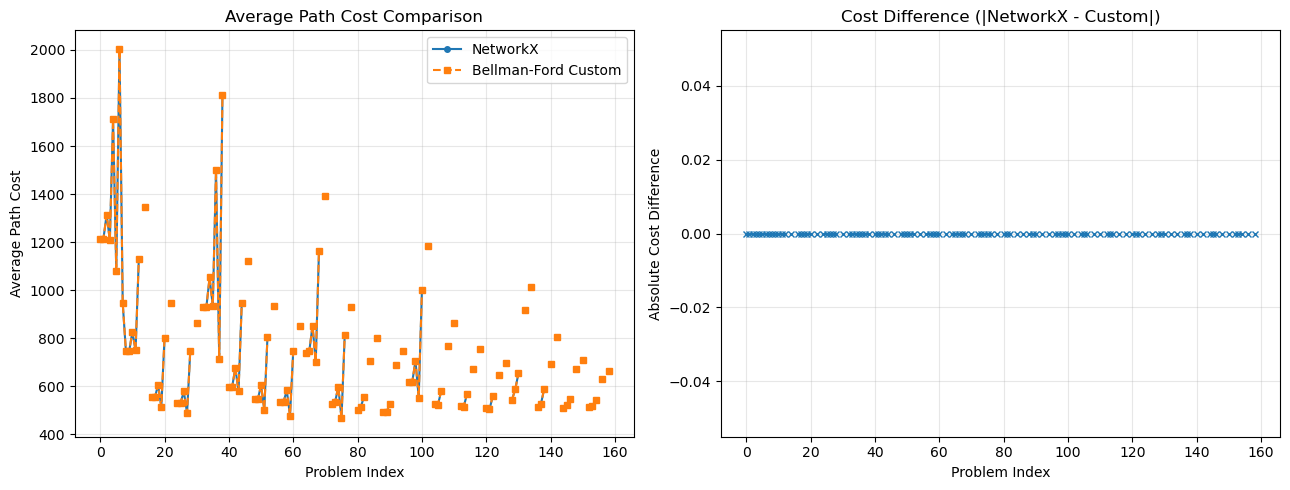

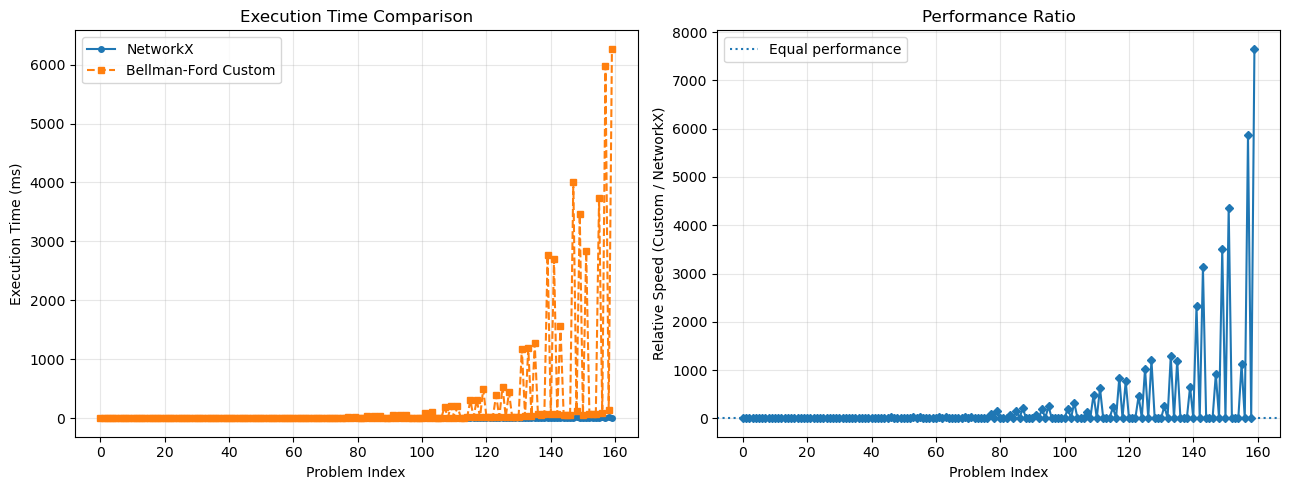


Benchmark complete! Results saved to 'result_optimized.csv'


In [9]:
# --- Visualization 1: Cost comparison ---
plt.figure(figsize=(13, 5))

# Subplot 1: average cost
plt.subplot(1, 2, 1)
plt.plot(df_agg['nx_avg'], label='NetworkX', marker='o', markersize=4)
plt.plot(df_agg['bellman_ford_avg'], 
         label='Bellman-Ford Custom', linestyle='--', marker='s', markersize=4)

plt.xlabel('Problem Index')
plt.ylabel('Average Path Cost')
plt.title('Average Path Cost Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: difference
plt.subplot(1, 2, 2)
cost_diff = (df_agg['nx_avg'] - df_agg['bellman_ford_avg']).abs()

plt.plot(cost_diff, marker='x', markersize=4)

plt.xlabel('Problem Index')
plt.ylabel('Absolute Cost Difference')
plt.title('Cost Difference (|NetworkX - Custom|)')
plt.grid(True, alpha=0.3)

# Apply log scale only if there are positive values
if (cost_diff > 0).any():
    plt.yscale('log')
else:
    print("No positive values: log scale not applied.")

plt.tight_layout()
plt.savefig('cost_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Visualization 2: Time comparison ---
plt.figure(figsize=(13, 5))

# Subplot 1: execution time
plt.subplot(1, 2, 1)
plt.plot(df_agg['nx_time_avg'] * 1000, label='NetworkX', marker='o', markersize=4)
plt.plot(df_agg['bellman_ford_time_avg'] * 1000, 
         label='Bellman-Ford Custom', linestyle='--', marker='s', markersize=4)

plt.xlabel('Problem Index')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: speed ratio
speedup = df_agg['bellman_ford_time_avg'] / df_agg['nx_time_avg']

plt.subplot(1, 2, 2)
plt.plot(speedup, marker='D', markersize=4)
plt.axhline(y=1.0, linestyle=':', label='Equal performance')

plt.xlabel('Problem Index')
plt.ylabel('Relative Speed (Custom / NetworkX)')
plt.title('Performance Ratio')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBenchmark complete! Results saved to 'result_optimized.csv'")